# Model training and prediction - `s30d`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

In [85]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d
tc_train = pd.read_csv("./data/processed/s30d/tc_train.csv", index_col = 0).tc
tc_test = pd.read_csv("./data/processed/s30d/tc_test.csv", index_col = 0).tc

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [8]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [9]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [12]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [13]:
# lgbm = Pipeline(steps=[("lightgbmclassifier", LGBMClassifier())])
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    # lgbm,
    lr,
    rf
]

In [14]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [15]:
from src.models.classifiers import StackedGeneralizationClassifier

In [16]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

Outer loop, each fold:
	Number of 0's: ~2930 (94.18%)
	Number of 1's: ~181 (5.82%)
Inner loop, each loop:
	Number of 0's: ~1465 (94.18%)
	Number of 1's: ~90 (5.82%)


In [17]:
y_test_pred_con, y_test_pred_cut = sgclf.predict(X_test)

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
auc_test_con = roc_auc_score(y_score = y_test_pred_con, y_true = y_test)
("Hold-out AUC of ROC, continous model: " + 
str(auc_test_con))

'Hold-out AUC of ROC, continous model: 0.9561028659160696'

In [20]:
auc_test_cut = roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)
("Hold-out AUC of ROC, cut model: " + 
str(auc_test_cut))

'Hold-out AUC of ROC, cut model: 0.9121545547594677'

In [21]:
from src.visualization.visualize import plot_roc, plot_precision_recall

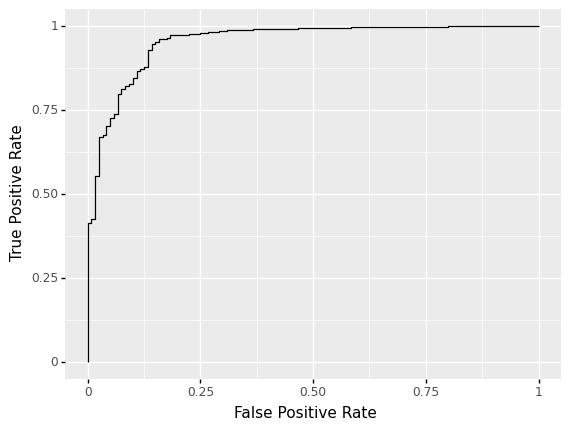

<ggplot: (352146423)>

In [22]:
plot_roc(y_test, y_test_pred_con)

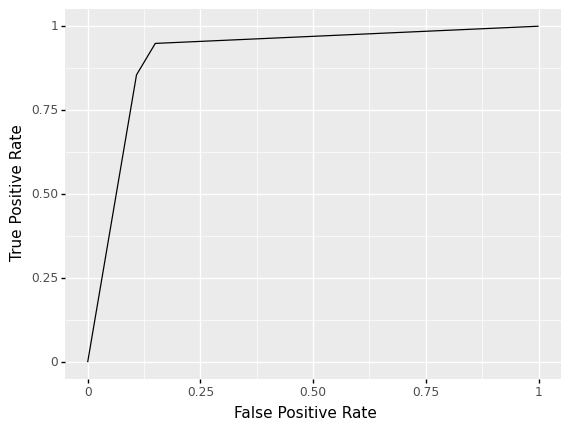

<ggplot: (369125181)>

In [23]:
plot_roc(y_test, y_test_pred_cut)

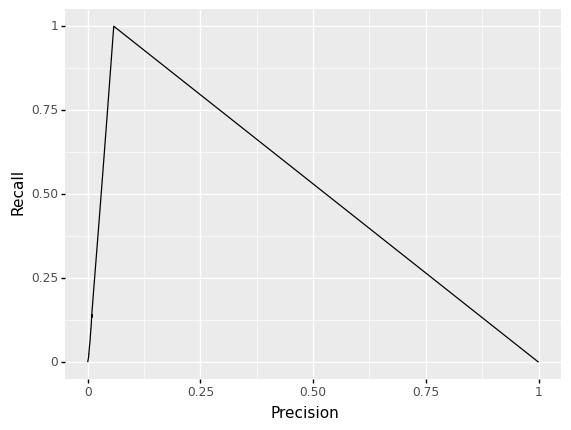

<ggplot: (369170069)>

In [24]:
plot_precision_recall(y_test, y_test_pred_con)

Plot roc curves for each classifier

In [25]:
from src.visualization.visualize import plot_roc_base_clfs

In [26]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [27]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [28]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [29]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [30]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_pred_con))

In [31]:
from src.models.metrics import calculate_nri

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


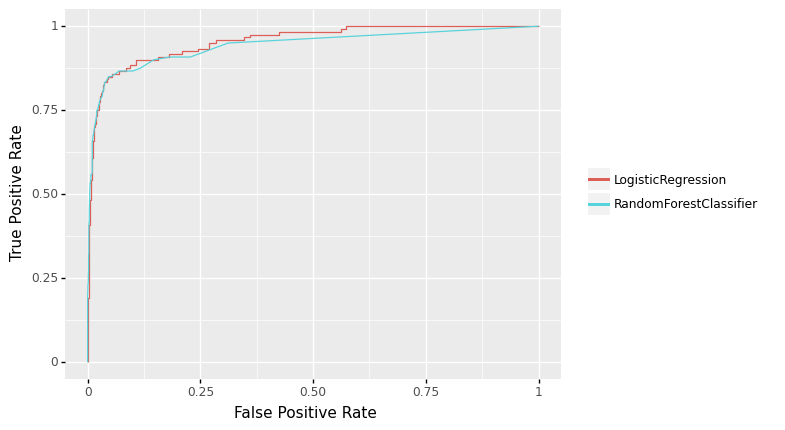

<ggplot: (382894363)>

In [34]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [35]:
from sklearn.utils import resample
from joblib import Parallel, delayed

In [81]:
def compute_performance(y_prob, y_pred, y_true, return_type: object = dict):
    roc_auc = roc_auc_score(
        y_true=y_true, 
        y_score=y_prob
    )
    prec = precision_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    rec = recall_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    r = (
        dict(roc_auc = roc_auc, prec = prec, rec = rec) if return_type == dict
        else pd.Series([roc_auc, prec, rec], index =["roc_auc", "prec", "rec"])
    )
    return r

def compute_metrics(X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series,
                    tc: pd.Series, keys: list):
    """Computes relevant performance metrics.
    
    ROC, Precision, Recall, and NRI for the meta classifier.
    """
    # Fit classifier
    sgclf = StackedGeneralizationClassifier(
        base_clfs=base_clfs, 
        meta_clf=LogisticRegression(),
        use_probas=True, 
        verbose=False
    )
    sgclf.cv_outer_loop(
        all_hyper_parameters=all_hyper_parameters,
        X=X_train, 
        y=y_train,
        refit=True
    )
    # Predictions by the meta classifier
    y_test_prob_con, y_test_prob_cut = sgclf.predict(X_test)
    y_test_pred_meta_clf = sgclf.predict(X_test, use_probas = False)
    
    # Predictions for each base classifier
    y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
    y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False) 

    # Merge the two
    y_preds = np.column_stack((y_test_pred_clfs, y_test_pred_meta_clf))
    y_probs = np.column_stack((y_test_prob_clfs, y_test_prob_con))
    
    ds = {key: compute_performance(y_prob=prob, y_pred=pred, y_true=y_test)
         for prob, pred, key in zip(y_probs.T, y_preds.T, keys)
    }
    ## Compute nri for the meta classifier
    nri_metrics = ["nri", "nri_plus", "nri_minus"]
    nri = calculate_nri(
        y_true=y_test, 
        y_old=tc,
        y_new=y_test_prob_cut
    )
    ds[keys[-1]] = {**ds[keys[-1]], **{m: nri[m] for m in nri_metrics}}
    
    return ds


def boot_compute_metrics(X: pd.DataFrame, y: pd.Series, 
                         training_size: int, keys: list):
    """Helper to refactor compute_metrics."""
    # Prepare training and test sets
    X_train = resample(X, n_samples=training_size)
    y_train = y.loc[X_train.index]
    X_test = X.loc[~X.index.isin(X_train.index), :]
    y_test = y.loc[X_test.index]

    return compute_metrics(
        X_train=X_train,
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        keys=keys
    )


def bootstrap(X: pd.DataFrame, y: pd.Series, tc, keys: list, N: int = 5,
              train_size: float = 0.8, n_jobs: int = 2):
    """Bootstraps statistics
    
    Parallelized computation of bootstrap performance estimates.
    
    Args:
        X: Features.
        y: Targets.
        N: Number of bootstrap samples.
        train_size: Proportion of samples in the training sample.
        n_jobs: Number of parallel processes.
        keys: Classifier keys.
        
    Returns:
        List of estimates from each bootstrap sample.
    """
    # Numbef of samples in training samples
    training_size = int(len(X.index) * train_size)
    return Parallel(n_jobs=n_jobs)(delayed(boot_compute_metrics)(X, y, tc, training_size, keys) for i in tqdm(range(N)))


def compute_bootstrap_ci(point_estimate, stats):
    """Computes confidence interval.
    
    Uses the empirical bootstrap.
    Source:
        https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
        
    Args:
        point_estimate: Point estimate from our sample.
        stats: Estimates from each bootstrap sample.
        
    Returns:
        Tuple of lower and upper bound of confidence interval.
    """
    bs_statistics = np.sort(stats)
    delta_star = bs_statistics - point_estimate
    d1 = np.quantile(delta_star, 0.1)
    d2 = np.quantile(delta_star, 0.9)
    ub = point_estimate - d1
    lb = point_estimate - d2
    
    return lb, ub

In [82]:
def compile_performance(y_probs: pd.DataFrame, y_preds: pd.DataFrame,
                        y_true: np.array, tc: np.array, y_cut: np.array,
                        keys: list):
    # Compute prec, rec, auc for all models
    ds = [
        compute_performance(y_prob=prob, y_pred=pred, y_true=y_true) 
        for prob, pred in zip(y_probs.T, y_preds.T)
    ]
    perf_df = pd.DataFrame(ds, index = keys)
    
    # Compute nri for meta classifier
    nri_metrics = ["nri", "nri_plus", "nri_minus"]
    nri = calculate_nri(
        y_true=y_true, 
        y_old=tc, 
        y_new=y_cut
    )
    nri_df = pd.DataFrame(
        np.zeros(perf_df.shape),
        columns=nri_metrics    
    ).replace({0: None})
    nri_df.loc[len(perf_df.index) - 1, :] = np.array(nri[nri_metrics])
    nri_df.index = perf_df.index

    perf_df = pd.concat([perf_df, nri_df], axis = 1)

    return perf_df

In [86]:
stats = bootstrap(X_train, y_train, tc_train, keys + [sgclf.__class__.__name__])

TypeError: 'list' object cannot be interpreted as an integer

In [66]:
stats

[{'LogisticRegression': {'roc_auc': 0.9643291029940362,
   'prec': 0.895252484296159,
   'rec': 0.808303128576879},
  'RandomForestClassifier': {'roc_auc': 0.9535357135685456,
   'prec': 0.8846306202718903,
   'rec': 0.7754083917347738},
  'StackedGeneralizationClassifier': {'roc_auc': 0.9642864314544468,
   'prec': 0.9041245476101336,
   'rec': 0.7763622261491194}},
 {'LogisticRegression': {'roc_auc': 0.9612312344148272,
   'prec': 0.8995547703637552,
   'rec': 0.7845869842777007},
  'RandomForestClassifier': {'roc_auc': 0.9335604946693524,
   'prec': 0.8767163599706975,
   'rec': 0.777325042751195},
  'StackedGeneralizationClassifier': {'roc_auc': 0.9578664503371698,
   'prec': 0.8919566213228705,
   'rec': 0.7721292169271685}},
 {'LogisticRegression': {'roc_auc': 0.956794425087108,
   'prec': 0.8752287092481703,
   'rec': 0.772486643437863},
  'RandomForestClassifier': {'roc_auc': 0.9523042973286876,
   'prec': 0.87858631009972,
   'rec': 0.7726771196283392},
  'StackedGeneralizatio

In [71]:
# Set bootstrap estimates as data frame
stats_df = pd.concat([pd.DataFrame.from_dict(d, orient="index").stack().to_frame() for d in stats], axis = 1)
stats_df.values.sort()
# Set point estimates as data frame
point_estimates = pd.DataFrame.from_dict({
    k: compute_performance(y_prob=prob, y_pred=pred, y_true=y_test) 
    for prob, pred, k in zip(y_test_prob_clfs.T, y_test_pred_clfs.T, keys + [sgclf.__class__.__name__])
}, orient = "index").stack().to_frame()
# Compute quantiles for each metric
d1 = (stats_df - point_estimates).apply(np.quantile, q = 0.1, axis = 1)
d2 = (stats_df - point_estimates).apply(np.quantile, q = 0.9, axis = 1)
# Compute upper bounds and lower bounds
ub = point_estimates - d1.to_frame()
lb = point_estimates - d2.to_frame()

In [76]:
ub

0
LogisticRegression              roc_auc  0.957818
                                prec     0.885905
                                rec      0.820259
RandomForestClassifier          roc_auc  0.951310
                                prec     0.880383
                                rec      0.790995
StackedGeneralizationClassifier roc_auc  0.960809
                                prec     0.920580
                                rec      0.850083

In [ ]:
compile_performance(
    y_preds=y_test_pred_clfs, 
    y_probs=y_test_prob_clfs, 
    y_true=y_test, 
    tc=tc_test,
    y_cut=y_test_pred_cut,
    keys=keys + [sgclf.__class__.__name__]
)

  0%|          | 0/4 [00:00<?, ?it/s]
Outer loop, each fold:
	Number of 0's: ~2355 (94.65%)
	Number of 1's: ~133 (5.35%)
Inner loop, each loop:
	Number of 0's: ~1178 (94.65%)
	Number of 1's: ~66 (5.35%)
  0%|          | 0/4 [00:00<?, ?it/s]
Outer loop, each fold:
	Number of 0's: ~2341 (94.09%)
	Number of 1's: ~147 (5.91%)
Inner loop, each loop:
	Number of 0's: ~1170 (94.09%)
	Number of 1's: ~74 (5.91%)
  0%|          | 0/4 [00:00<?, ?it/s]
Outer loop, each fold:
	Number of 0's: ~2341 (94.09%)
	Number of 1's: ~147 (5.91%)
Inner loop, each loop:
	Number of 0's: ~1170 (94.09%)
	Number of 1's: ~74 (5.91%)
  0%|          | 0/4 [00:00<?, ?it/s]
Outer loop, each fold:
	Number of 0's: ~2354 (94.61%)
	Number of 1's: ~134 (5.39%)
Inner loop, each loop:
	Number of 0's: ~1177 (94.61%)
	Number of 1's: ~67 (5.39%)
  0%|          | 0/4 [00:00<?, ?it/s]
Outer loop, each fold:
	Number of 0's: ~2346 (94.29%)
	Number of 1's: ~142 (5.71%)
Inner loop, each loop:
	Number of 0's: ~1173 (94.29%)
	Number of 1'